In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os
import re
from tqdm import tqdm, trange

#sns.set_theme()

def load_data_files(path, name=None):
    data = None
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
    else:
        for file in os.listdir(path):
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            if data is None:
                data = run
            else:
                data = data.append(run, ignore_index=True)
    if name is not None:
        data["Name"] = name
    return data

def set_fixed_steps(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in tqdm((range(n_runs))):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range)].index)
            
            if len(ids) == 0:
                print("hin?")
                continue
                
            shuffled_ids = random.sample(ids, len(ids))
            keep_id = shuffled_ids[0]
            drop_ids += shuffled_ids[1:]
            
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg(data, max_steps=10000000, step_range=100, n_runs=11):
    index_range = int(step_range / 30) + 1
    drop_ids = []
    start_index = data.index[0]
    for i in trange(n_runs):
        for s_i in range(0, max_steps, step_range):
            rows = data[(data.index >= start_index) & (data.index < start_index + index_range)]["Step"]
            ids = list(rows[(rows  >= s_i) & (rows  < s_i + step_range + 1000)].index)
            
            if len(ids) == 0:
                #print(rows, s_i, "hin?")
                continue
            
            keep_id = ids[0]
            drop_ids += ids[1:]
            # For all numerical columns but the 'Step'
            for c in data.select_dtypes(include=np.number).columns:
                if c == "Step":
                    continue
                data.at[keep_id, c] = data.loc[ids][c].mean()
            data.at[keep_id, "Step"] = s_i + step_range
            
            start_index = ids[-1] + 1
    return data.drop(drop_ids)

def mov_avg_index(data, n_index=10, diplay_prog=True):
    drop_ids = []
    range_fn = trange if diplay_prog else range
    for i in range_fn(0, len(data), n_index):
        ids = list(range(i, min(i + n_index, len(data))))
        keep_id = ids[-1]
        drop_ids += ids[:-1]
        # For all numerical columns but the 'Step'
        for c in data.select_dtypes(include=np.number).columns:
            if c == "Step":
                continue
            data.at[keep_id, c] = data.loc[ids][c].mean()
    return data.drop(drop_ids)

def plot_runs(runs, x="Step", y="Episode return", estim="mean", err="sd", 
               ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
               names=None, colors=None, loc='best', size=(15, 6)):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    if ylim is not None:
        ax.set(ylim=ylim)
    #for r_i in range(len(runs)):
    #    sns.lineplot(data=runs[r_i], 
    #                 x=x, y=y, hue="Name", ax=ax, estimator=estim, errorbar=err, palette=colors)
    sns.lineplot(data=runs, x=x, y=y, hue="Name", 
                 ax=ax, estimator=estim, errorbar=err, 
                 palette=colors, legend="brief")
    #if names is not None:
    #    ax.legend(names, loc=loc, frameon=False)
    #else:
    ax.legend(loc=loc, frameon=False)
        
def box_plot_runs(runs, x="Step", y="Mean return", 
             ax=None, ax_xlabel=None, ax_ylabel=None, ylim=None, 
             legend=True, names=None, loc='best', size=(15, 6), 
             only_one_step=None, swarm=False, swarm_size=3, colors=None):
    if type(runs) is list:
        runs = pd.concat(runs, ignore_index=True)
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    if ylim is not None:
        ax.set(ylim=ylim, xlabel=ax_xlabel, ylabel=ax_ylabel)
    if only_one_step is not None:
        runs = runs.loc[runs["Step"] == only_one_step]
        x = "Name"
    if swarm:
        sns.swarmplot(x=x, y=y, hue="Name", data=runs, ax=ax, size=swarm_size, palette=colors)
        plt.setp(ax.get_xticklabels(), rotation=30)#, horizontalalignment="right")
    else:
        sns.boxplot(x=x, y=y, hue="Name", data=runs, ax=ax, palette=colors)
    if legend:
        if names is not None:
            ax.legend(names, loc=loc)
        else:
            ax.legend(loc=loc)
    else:
        ax.get_legend().remove()
    if ax_xlabel is not None:
        ax.set(xlabel=ax_xlabel)
    if ax_ylabel is not None:
        ax.set(ylabel=ax_ylabel)
    return ax
        
def load_plot_runs(path, y="Episode extrinsic return", n_index_avg=100, separate_graphs=True, ax=None,
                   ax_xlabel=None, ax_ylabel=None):
    if os.path.isfile(path):
        data = pd.read_csv(path, index_col=0)
        # TODO Plot single run
        
    else:
        if not separate_graphs and ax is None:
            fig, ax = plt.subplots(figsize=(15, 6))
        if ax_xlabel is not None:
            ax.set(xlabel=ax_xlabel)
        if ax_ylabel is not None:
            ax.set(ylabel=ax_ylabel)
        for file in os.listdir(path):
            print(file)
            run = pd.read_csv(os.path.join(path, file), index_col=0)
            #run = mov_avg(run, step_range=step_range, n_runs=1)
            run = mov_avg_index(run, n_index=n_index_avg)
            if separate_graphs:
                fig, ax = plt.subplots(figsize=(15, 6))
                ax.plot(run["Step"], run[y])
                plt.show()
            else:
                ax.plot(run["Step"], run[y])
        plt.show()
        
def load_mov_avg(dir_path, name, avg_range=100000, max_steps=10000000):
    runs = []
    for file in os.listdir(dir_path):
        print(file, end=' - ')
        # Load file
        run = pd.read_csv(os.path.join(dir_path, file), index_col=0)
        # Move average
        avg_runs = []
        for s_i in range(0, max_steps, avg_range):
            range_rows = run[(run["Step"] > s_i) & (run["Step"] <= s_i + avg_range)]
            
            row = {}
            for c in run.columns:
                if c == "Step":
                    row["Step"] = s_i + avg_range
                else:
                    row[c] = range_rows[c].mean()

            avg_runs.append(row)
        runs.append(pd.DataFrame(avg_runs))
    all_runs = pd.concat(runs)
    all_runs["Name"] = name
    return all_runs

run1.csv


100%|██████████████████████████████████████| 3308/3308 [00:05<00:00, 576.78it/s]


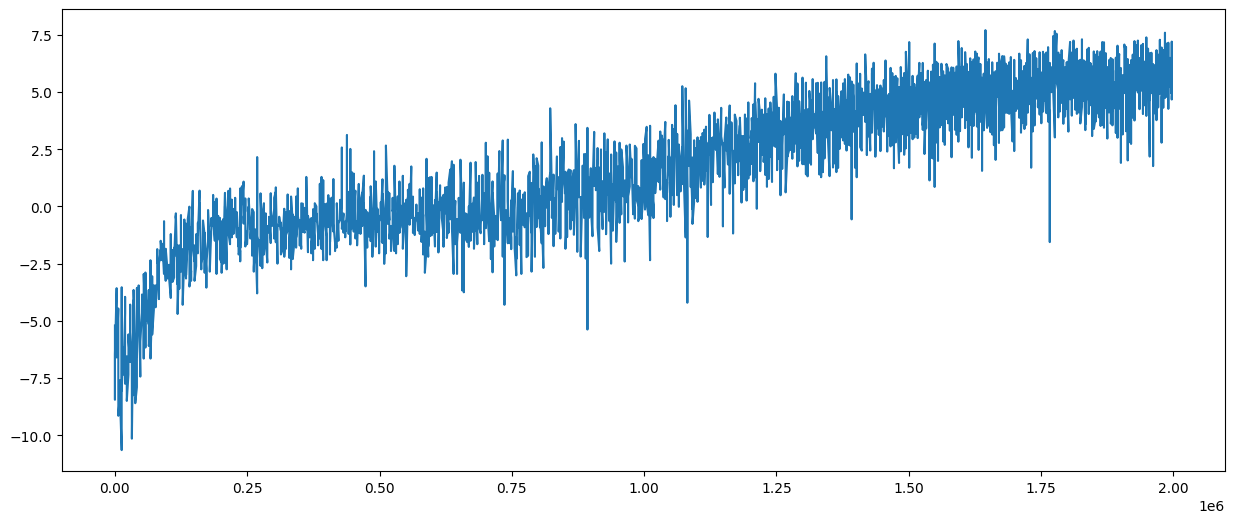

In [17]:
load_plot_runs("../models/magym_PredPrey/mappo_perfectcomm_9x9/train_data/", "Episode return", 100)

run7.csv


100%|████████████████████████████████████████| 409/409 [00:00<00:00, 409.92it/s]


run8.csv


100%|████████████████████████████████████████| 388/388 [00:00<00:00, 402.43it/s]


run5.csv


100%|████████████████████████████████████████| 348/348 [00:00<00:00, 411.21it/s]


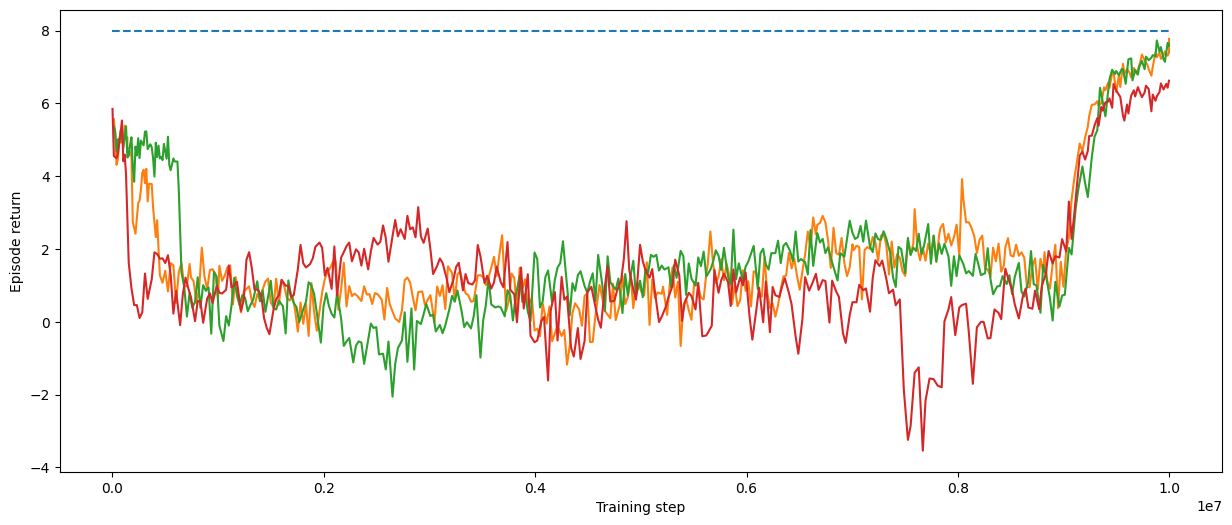

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot([0, 10000000], [8, 8], linestyle="--")
load_plot_runs("../models/magym_PredPrey/FT_nocommenc/train_data/", "Episode return", 500, False, ax,
               ax_xlabel="Training step", ax_ylabel="Episode return")

In [85]:
FT_commenc = load_mov_avg("../models/magym_PredPrey/FT_commencmappo/train_data/", "MAPPO_commenc", 20000)

run2.csv


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 419.58it/s]


run4.csv


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 411.52it/s]


run1.csv


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 392.67it/s]


run2_od.csv


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 361.56it/s]


run3_od.csv


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 352.60it/s]


run1_r.csv


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 370.98it/s]


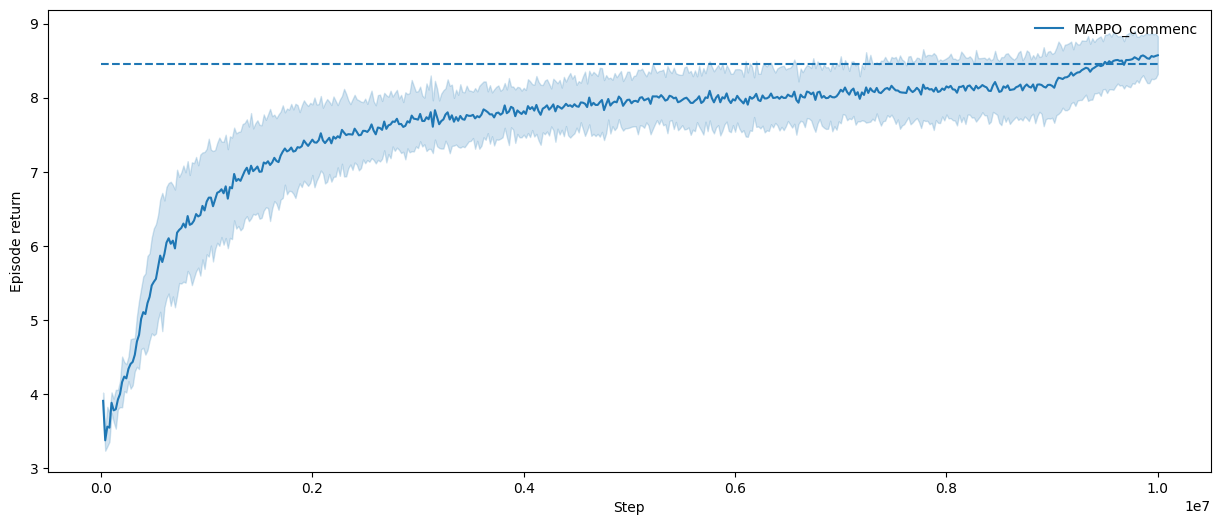

In [90]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot([0, 10000000], [8.45, 8.45], linestyle="--")
plot_runs(FT_commenc, y="Episode return", ax=ax)

run2.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1310.44it/s]


run4.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1254.96it/s]


run3.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1110.56it/s]


run1.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1157.82it/s]


run7.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1213.27it/s]


run9.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1293.53it/s]


run11.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1305.35it/s]


run8.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1156.00it/s]


run6.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1303.22it/s]


run10.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1191.44it/s]


run5.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1320.09it/s]


run2.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1263.24it/s]


run4.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1245.21it/s]


run3.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1115.73it/s]


run1.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1208.12it/s]


run7.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1300.02it/s]


run9.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1254.25it/s]


run11.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1247.19it/s]


run8.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1142.63it/s]


run6.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1319.00it/s]


run10.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1211.01it/s]


run5.csv


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1211.11it/s]


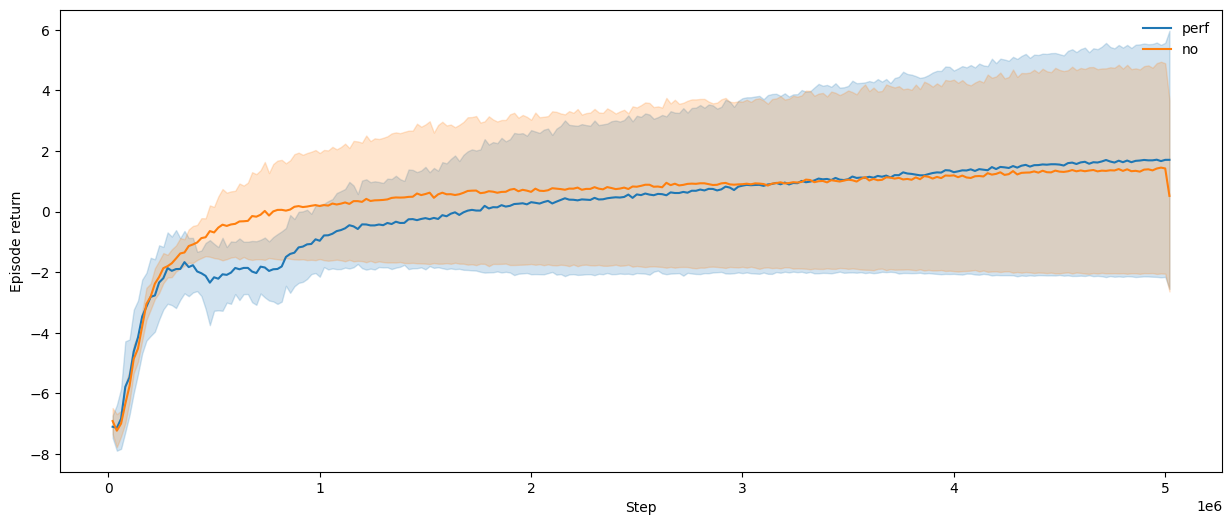

In [9]:


perf_comm = load_mov_avg(
    "../models/magym_PredPrey/ACC_NO-SHAREDOBS-AUGMENT_8x8_pt_perfect_comm/train_data/", 
    "perf", 
    20000)
no_comm = load_mov_avg(
    "../models/magym_PredPrey/ACC_NO-SHAREDOBS-AUGMENT_8x8_pt_no_comm/train_data/", 
    "no", 
    20000)

plot_runs([perf_comm, no_comm], y="Episode return")

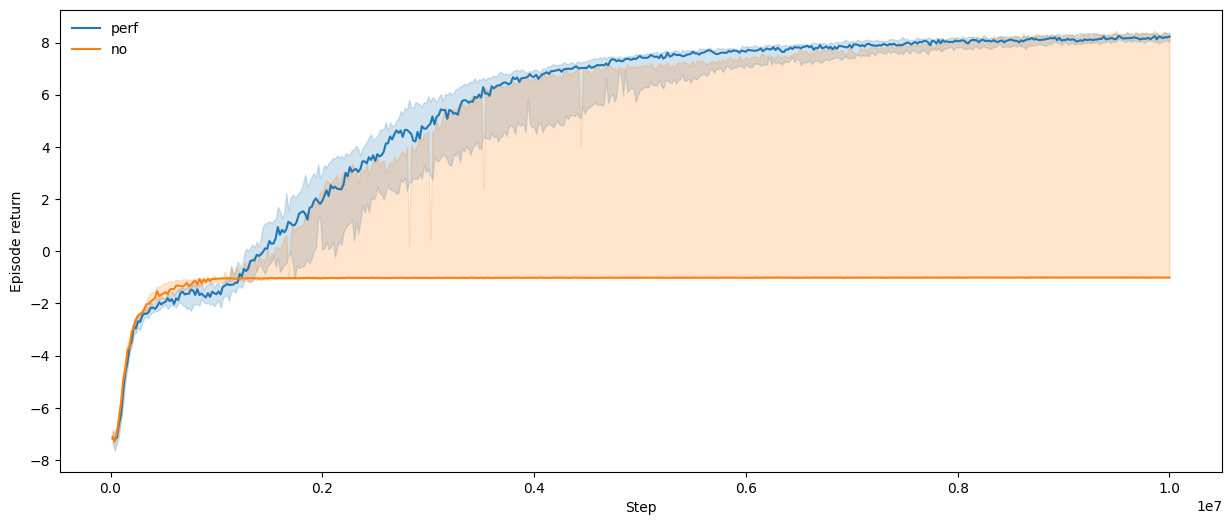

In [12]:
perf_comm = load_mov_avg(
    "../models/magym_PredPrey/ACC_9x9_pt_perfect_comm/train_data/", 
    "perf", 
    20000)
no_comm = load_mov_avg(
    "../models/magym_PredPrey/ACC_9x9_pt_no_comm/train_data/", 
    "no", 
    20000)

plot_runs([perf_comm, no_comm], y="Episode return", estim="median", err="ci")

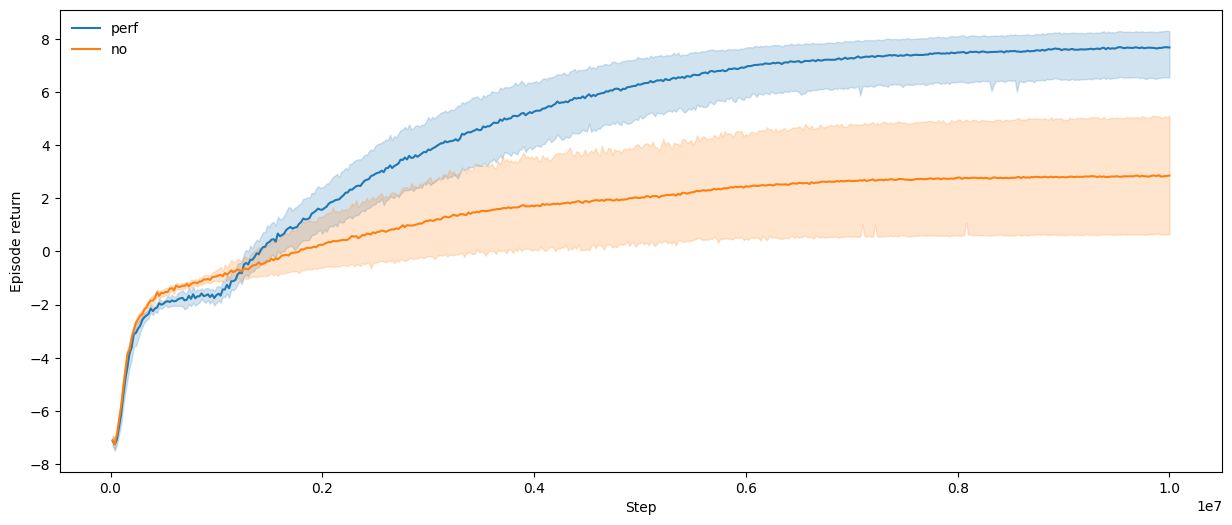

In [14]:
plot_runs([perf_comm, no_comm], y="Episode return", err="ci")

run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run8.csv - run6.csv - run5.csv - run2.csv - run4.csv - run3.csv - run1.csv - run7.csv - run9.csv - run11.csv - run8.csv - run6.csv - run10.csv - run5.csv - 

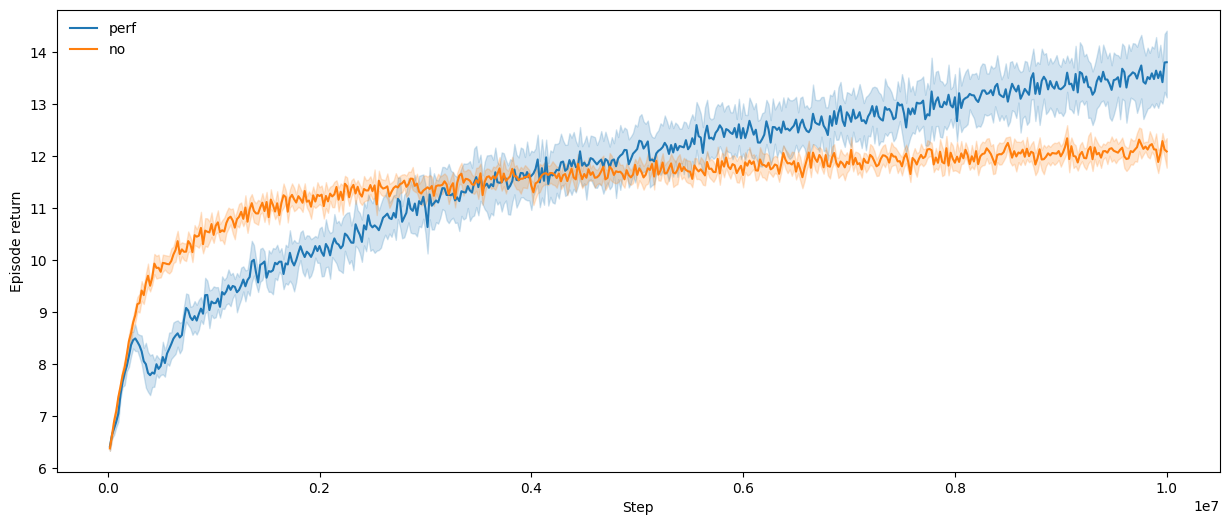

In [17]:
perf_comm = load_mov_avg(
    "../models/magym_Foraging/ACC_10x10_pt_perfect_comm/train_data/", 
    "perf", 
    20000)
no_comm = load_mov_avg(
    "../models/magym_Foraging/ACC_10x10_pt_no_comm/train_data/", 
    "no", 
    20000)

plot_runs([perf_comm, no_comm], y="Episode return", err="ci")